In [105]:
import json
import urllib 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

In [106]:
#county='WashDC'
#county='Baltimore_'
#county='NewYorkCity_'
#county='Philadelphia_'

cities = ['WashDC','Baltimore_','Suffolk','Philadelphia_']

In [11]:
#DONT RUN - this is for making hashmap from URL
params = {}
url='https://aqs.epa.gov/data/api/list/parametersByClass?email=samavedamanjali@gmail.com&key=russetcrane95&pc=CRITERIA'
with urllib.request.urlopen(url) as urlhandle:
    params = json.loads(urlhandle.read().decode())

params_dict = {}
for i in params['Data']:
    #print (i['code'], i['value_represented'])
    params_dict[i['code']] = i['value_represented']
del params_dict['14129']  # Some issue with data for this; ignore for now
del params_dict['81102']
del params_dict['85129']
print (params_dict)

{'42101': 'Carbon monoxide', '42401': 'Sulfur dioxide', '42602': 'Nitrogen dioxide (NO2)', '44201': 'Ozone', '88101': 'PM2.5 - Local Conditions'}


In [107]:
params_dict = {'42101': 'CarbonMonoxide', '42401': 'SulfurDioxide', '42602': 'NitrogenDioxide',
               '44201': 'Ozone', '88101': 'PM2.5LocalConditions'}
params_who_limits = {'42101': 6, '42401': 7.633587786, '42602': 53.19148936,
               '44201': 0.05102040816, '88101': 25}

In [13]:
#DONT RUN - we already have data in the files
def get_param_data(p,y):
    url='https://aqs.epa.gov/data/api/dailyData/byCounty?email=samavedamanjali@gmail.com&key=russetcrane95&param=' + p + '&bdate=' + y + '0101&edate=' + y + '1231&state=24&county=005'    
    with urllib.request.urlopen(url) as urlhandle:
        data = json.loads(urlhandle.read().decode())
        #print(json.dumps(data))
    df = pd.DataFrame.from_dict(data['Data'])
    return df
    #dfc.groupby('date_local').mean().plot(figsize=(15,5))

In [108]:
def readAndDisplayFile(c,p,y):
    f_name = '../Anjali/data/'+c+p+'_'+y+'.json'
    #print(f_name)
    with open(f_name) as json_file:
        data = json.load(json_file)
        #print(data)
        df = pd.DataFrame.from_dict(data['Data'])

        if (df.size != 0) :
            # get only the needed cols out of 30+ columns
            df = df[['date_local','arithmetic_mean']]
            # agggregate by date so that we have one value per day
            df = df.groupby('date_local').mean().reset_index()
        return df;
    
#df = readAndDisplayFile('Baltimore','p','2011');

In [109]:
def readAndDisplayFileYearRange(c,px,ya,yb):
    #print(c,px,ya,yb)
    # Create Empty DF
    df_ab = pd.DataFrame()
    for y in range(ya,yb):
        df1 = readAndDisplayFile(c,px,str(y));
        df_ab = df_ab.append(df1,ignore_index=True)
    return df_ab
      
#df = readAndDisplayFile('Baltimore','p','2011');

Baltimore_


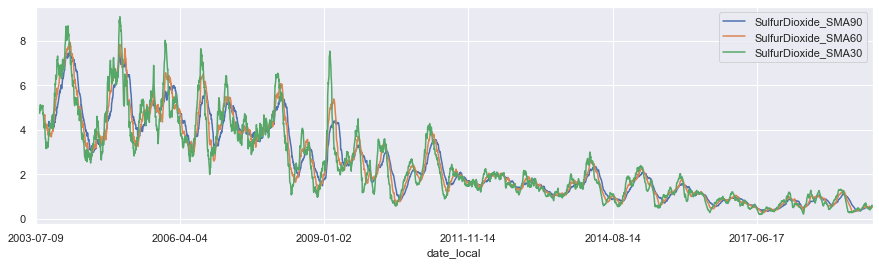

In [74]:
#to test plotting
p='42401'
pn=params_dict[p]
df = readAndDisplayFileYearRange(county,p,2001,2020)  
df.columns = ['date_local', params_dict[p]]
df[pn+'_SMA90'] = df.iloc[:,1].rolling(window=90).mean()
df[pn+'_SMA60'] = df.iloc[:,1].rolling(window=60).mean()
df[pn+'_SMA30'] = df.iloc[:,1].rolling(window=30).mean()
df = df.drop([params_dict[p]], axis=1)
df.groupby('date_local').mean().plot(figsize=(15,4))

42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


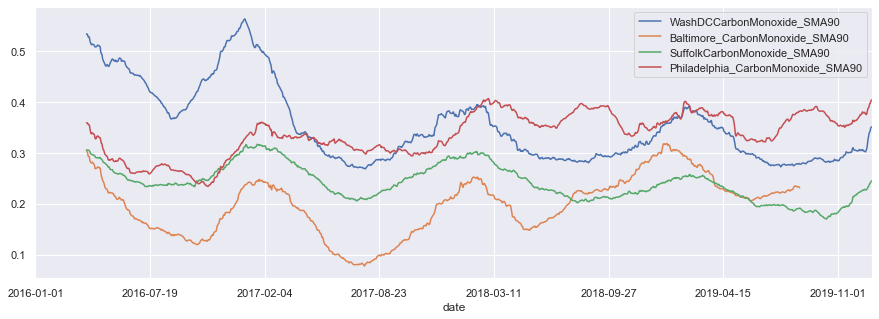

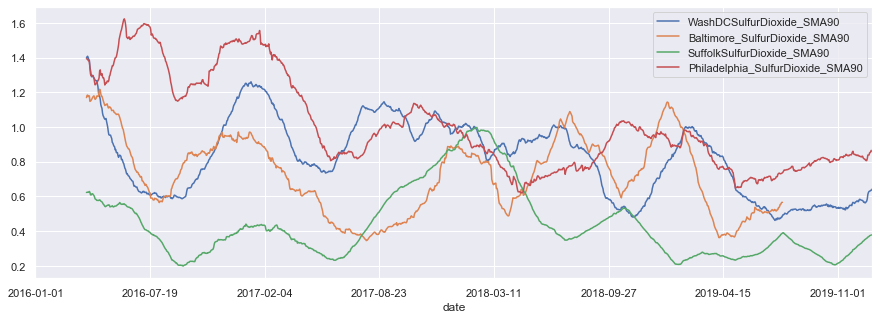

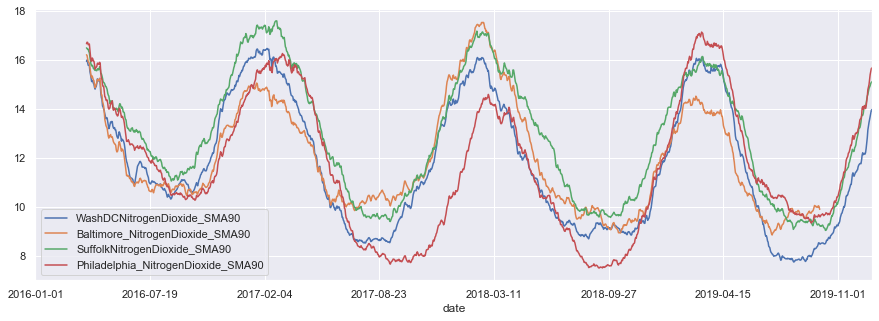

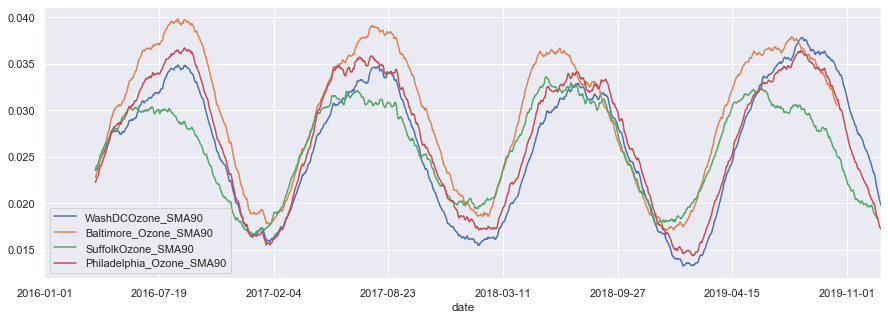

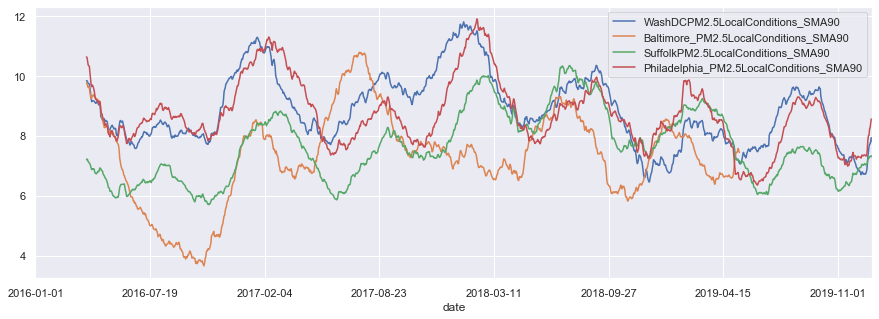

In [117]:
# For each pollutant, read the data into the DFs
for p in params_dict.keys():
    print(p, params_dict[p])
    pn=params_dict[p]
    df_cities = pd.DataFrame()
    for c in cities:
        df = readAndDisplayFileYearRange(c,p,2016,2020)    
        df.columns = ['date_local', params_dict[p]]
        df[pn+'_SMA90'] = df.iloc[:,1].rolling(window=90).mean()
        df_cities['date'] = df['date_local']
        df_cities[c+pn+'_SMA90'] = df[pn+'_SMA90']
    df_cities.groupby('date').mean().plot(figsize=(15,5))

In [101]:
def YEARLYfrequencyAboveWHO():
    #params_who_limits
    for p in params_dict.keys():
        print(p, params_dict[p])
        pn = params_dict[p]
        w = params_who_limits[p]
        df_cities = pd.DataFrame()
        counts_per_year = {}
        yrs = []

        for y in range(2001,2020):
                yrs.append(y)
        counts_per_year['years'] = yrs
        col_names = ['years']
        for c in cities:
            df = readAndDisplayFileYearRange(c,p,2001,2020)    
            df['date_local'] = pd.to_datetime(df['date_local'])
            df.columns = ['date_local', pn]
            counts = []
            col_names.append(c+pn)
            for y in range(2001,2020):
                df_y = df[(df['date_local'].dt.year == y) & (df[pn] > w)]
                counts.append(df_y.count()[0])
                #print(c, pn, y, w, df_y.count()[0])
            counts_per_year[c + pn] = counts
        df = pd.DataFrame(counts_per_year, columns = col_names)
        #df.groupby('years').mean().plot(figsize=(15,5))
        ax = df.plot.bar(x='years', rot=0,figsize=(15,5))        
        
        #df = pd.DataFrame({'years':['A', 'B', 'C'], 'val':[10, 30, 20]})


In [114]:
def MONTHLYfrequencyAboveWHO():
    #params_who_limits
    for p in params_dict.keys():
        print(p, params_dict[p])
        pn = params_dict[p]
        w = params_who_limits[p]
        df_cities = pd.DataFrame()
        counts_per_month = {}
        months = []

        for m in range(0,12):
                months.append(m)
        counts_per_month['months'] = months
        col_names = ['months']
        for c in cities:
            df = readAndDisplayFileYearRange(c,p,2001,2020)    
            df['date_local'] = pd.to_datetime(df['date_local'])
            df.columns = ['date_local', pn]
            counts = []
            col_names.append(c+pn)
            for m in range(0,12):
                df_m = df[(df['date_local'].dt.month == m) & (df[pn] > w)]
                counts.append(df_m.count()[0])
                #print(c, pn, y, w, df_y.count()[0])
            counts_per_month[c + pn] = counts
        df = pd.DataFrame(counts_per_month, columns = col_names)
        #df.groupby('years').mean().plot(figsize=(15,5))
        ax = df.plot.bar(x='months', rot=0,figsize=(15,5))        
        
        #df = pd.DataFrame({'years':['A', 'B', 'C'], 'val':[10, 30, 20]})


42101 CarbonMonoxide
42401 SulfurDioxide
42602 NitrogenDioxide
44201 Ozone
88101 PM2.5LocalConditions


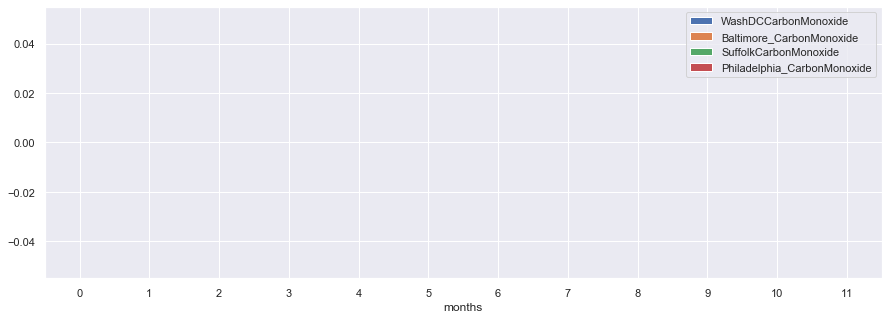

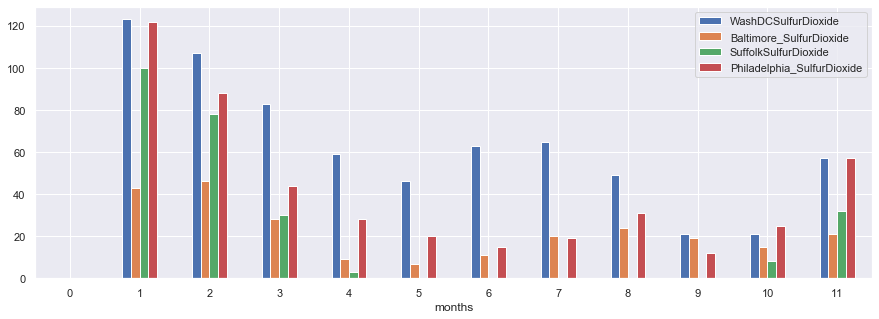

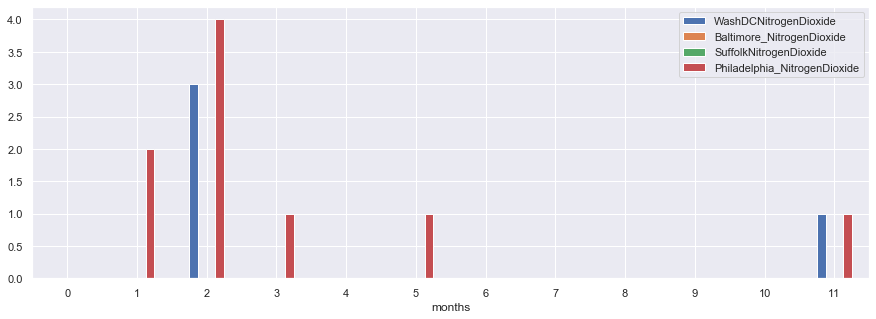

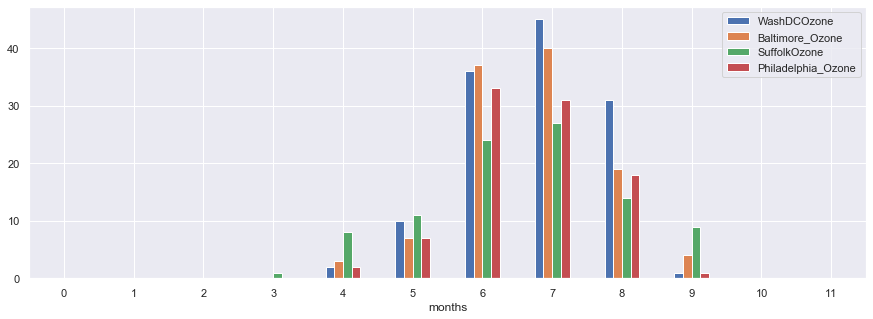

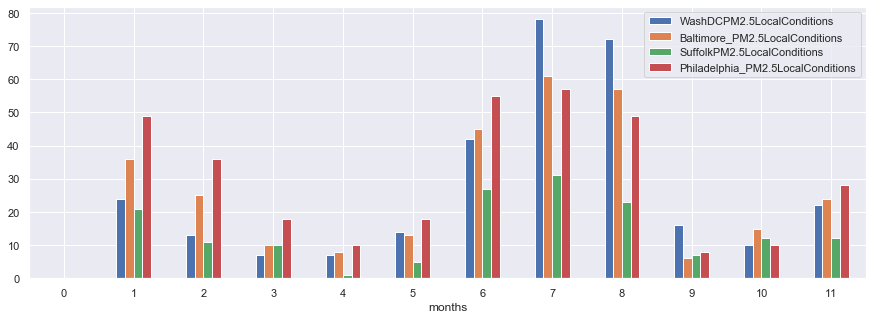

In [115]:
MONTHLYfrequencyAboveWHO()

In [96]:
def dayofyear():
    x = datetime.date(2019, 4, 13)
    y = datetime.date(2019,4,14)
    one_day = y-x
    num_days = datetime.date(2011, 12, 31) - datetime.date(2010, 1, 1)
    begin = datetime.date(2010, 1, 1)
    end = datetime.date(2011, 12, 31)
    for d in range(0, num_days.days):
        newDate = (str(begin + (d*one_day)))
        print(newDate)
    return newDate

#dayofyear()

In [ ]:
df_master = {}

for p in params_dict.keys():
    print(p, params_dict[p])
    df = readAndDisplayFileYearRange(county,p,2010,2020)    
    #df.columns = ['date_local', params_dict[p]]
    df_master[p] = df;  

In [151]:
x = datetime.date(2019, 4, 13)
y = datetime.date(2019,4,14)
one_day = y-x
num_days = datetime.date(2011, 12, 31) - datetime.date(2011, 1, 1)
begin = datetime.date(2011, 1, 1)
end = datetime.date(2011, 12, 31)

data_master = {}
data_master['date_local'] = []
for p in params_dict.keys():
    data_master[p] = []
    
df_new = pd.DataFrame(data_master)            

for d in range(0, num_days.days):
    new_date = str(begin + (d*one_day))
    data_master['date_local'].append(new_date)
    for p in params_dict.keys():
        df = df_master[p]
        try:
            val = df[df.date_local==new_date]['arithmetic_mean'].values[0]
            #print(new_date,p, val)
            data_master[p].append(val)
            #print (data_master[p])
        except:
            data_master[p].append(0) #### TBD to think about missing data later 

df_new = pd.DataFrame(data_master)            

In [8]:
sns.set()
cols = params_dict.keys()
sns.pairplot(df_new[cols], height=2.5)
plt.show()

NameError: name 'df_new' is not defined

In [9]:
corrmat = df_new.corr()
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(corrmat, vmax = 1, square = True, annot = True)

NameError: name 'df_new' is not defined

In [10]:
corrmat

NameError: name 'corrmat' is not defined